In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
# from lmfit.models import GaussianModel

In [131]:
import glob

In [2]:
c1 = 'cornflowerblue'
c2 = 'navy'
c3 = 'rebeccapurple'
c4 = '#CF6275'
c5 = 'maroon'

In [221]:
#functions to save a figure
def ps(name):
    '''save as postscript file'''
    plt.savefig(name+'.ps')
def png(name,dpi=200):
    '''save as png with sufficient quality'''
    plt.savefig('Figs/'+name+'.png',dpi=dpi,bbox_inches='tight')

# Identify Sources to Start With

In [108]:
from astropy.table import Table,join,vstack,unique

In [59]:
#load in names of OGLE sources in each of II,III,IV that is in part I (known pulsations)
og2 = Table.read('smc_list/PART1_OII.list',names=['src_n','name1','name2'],format='ascii')
og3 = Table.read('smc_list/PART1_OIII.list',names=['src_n','name1','name2'],format='ascii')
og4 = Table.read('smc_list/PART1_OIV.list',names=['src_n','name1'],format='ascii')

In [73]:
og4n = np.array(og4['src_n'])

In [80]:
len(og4n)

63

In [78]:
len(og4n[0])

1

In [84]:
#make filter by only taking, for now, src numbers without letters
int_inds = [0] #indices of integer src numbers
# c = 0
for i in range(1,len(og4n)):
    if len(og4n[i])>len(og4n[i-1]) and len(og4n[i])>len(og4n[i+1]):
        print(og4n[i])
    else: int_inds.append(i)

4a
14b
22a
34a
40a


In [85]:
og4_filt = og4[int_inds]

In [94]:
og4_filt[:3]

src_n,name1
str3,str15
2,smc732.03.3540
3,smc720.17.50
4,smc718.01.10792


In [95]:
og4_filt['src_n'].dtype

dtype('<U3')

In [101]:
og4int = Table(og4_filt,dtype=('int32','str'))

In [102]:
og4int[:2]

src_n,name1
int32,str15
2,smc732.03.3540
3,smc720.17.50


In [111]:
#table with src numbers and names from all three ogle
allog = vstack([og2,og3,og4int])
#only keep unique src numbers
allog = unique(allog,keys='src_n')

In [43]:
#cross-match with ascii file with all sources
smc = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

In [44]:
smc[:1]

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64
1,OGLE,RA,DEC,19.271511,-73.443405,0.5,0.717,3.892,19.27120833333333,-73.44333333333334,77458,13.15,0.4041071611446303,19.271369999999997,-73.44318999999999,13.152,5068334,0.7879504646408463


In [113]:
#smc just in part 1
p1 = join(smc,allog,keys='src_n')

58 sources total in part 1
-later add sources with 'a'
- start with a couple plots and then get into LCs

In [114]:
p1.columns

<TableColumns names=('src_n','OGLE','RA_OGLE','DEC_OGLE','ra_deg','dec_deg','perr','period','Porb','_RAJ2000_1','_DEJ2000_1','__M2002_','Vmag_1','Separation_1','_RAJ2000_2','_DEJ2000_2','Vmag_2','recno','Separation','name1','name2')>

Text(0.5, 0, 'Spin Period (s)')

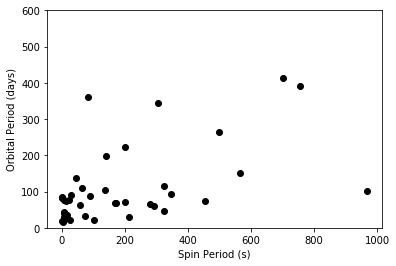

In [129]:
plt.scatter(p1['period'],p1['Porb'],color='black')
plt.ylim(0,600)
plt.ylabel('Orbital Period (days)')
plt.xlabel('Spin Period (s)')

# Example LC Using OII-OIV

In [123]:
#find sources that are in all three og2-og4
inall = join(og2,og3,keys='src_n')

In [125]:
inall = join(inall,og4int,keys='src_n')

In [126]:
inall

src_n,name1_1,name2_1,name1_2,name2_2,name1
int64,str15,str15,str15,str14,str15
6,smc719.18.378,smc_sc7.266703,smc719.18.378,smc108.8.26225,smc719.18.378
7,smc726.29.18,smc_sc9.146936,smc726.29.18,smc110.6.4726,smc726.29.18
10,smc719.18.465,smc_sc8.46134,smc719.18.465,smc108.1.28028,smc719.18.465
11,smc719.12.35646,smc_sc6.85614,smc719.12.35646,smc101.3.5189,smc719.12.35646
12,smc720.28.40399,smc_sc5.111490,smc720.28.40399,smc100.7.58825,smc720.28.40399
15,smc720.28.190,smc_sc4.156251,smc720.28.190,smc100.8.14642,smc720.28.190
16,smc720.26.47,smc_sc6.99923,smc720.26.47,smc100.1.43671,smc720.26.47
21,smc720.28.40482,smc_sc4.171264,smc720.28.40482,smc100.7.50768,smc720.28.40482
24,smc719.19.162,smc_sc7.70829,smc719.19.162,smc108.8.8659,smc719.19.162


In [141]:
#just grab the first source that's in all og
#later can change indexing to just use src_n?
src6 = p1[p1['src_n']==6]

In [139]:
#files in I band folder of OGLE II
iog2 = glob.glob('smc_list/OGLE-II/I/*')

In [174]:
iog3 = glob.glob('smc_list/OGLE-III/I/*')
iog4 = glob.glob('smc_list/OGLE-IV/I/*')

In [159]:
#how to isolate string of name
name6 = src6['name2'][0]
name6

'smc_sc7.266703'

In [177]:
name6_1 = src6['name1'][0]
name6_1

'smc719.18.378'

In [161]:
#loop thru files to find file with this src name
for i in iog2:
    if name6 in i:
        print(i)
        src6og2i = i

smc_list/OGLE-II/I/smc_sc7.266703.dat


In [192]:
name6_og3 = og3[og3['src_n']==6]['name2'][0]

In [193]:
name6_og3

'smc108.8.26225'

In [194]:
#repeat for other two file lists
#see note below about this
for i in iog3:
    if name6_og3 in i:
        print(i)
        src6og3i = i

smc_list/OGLE-III/I/smc108.8.26225.dat


In [188]:
for i in iog4:
    if name6_1 in i or name6 in i:
        print(i)
        src6og4i = i

smc_list/OGLE-IV/I/smc719.18.378.dat


will have to use names from original tables rather than merged
- example here where the names taken from the merged part 1 list won't work on og3; need original og3 table

In [213]:
#load in lightcurve
#just means I band og2 for src 6
i26 = Table.read(src6og2i,format='ascii',names=['MJD-50000','I mag','I mag err'])
i36 = Table.read(src6og3i,format='ascii',names=['MJD-50000','I mag','I mag err'])
i46 = Table.read(src6og4i,format='ascii',names=['MJD-50000','I mag','I mag err'])

In [203]:
iog4cal = glob.glob('smc_list/OGLE-IV/I/CALIBRATED/*')

In [204]:
#find calibrated version
for i in iog4cal:
    if name6_1 in i or name6 in i:
        print(i)
        src6og4ical = i

smc_list/OGLE-IV/I/CALIBRATED/smc719.18.378.dat


In [212]:
#compare to og4 calibrated version
i46cal = Table.read(src6og4ical,format='ascii',names=['MJD-50000','I mag','I mag err'])

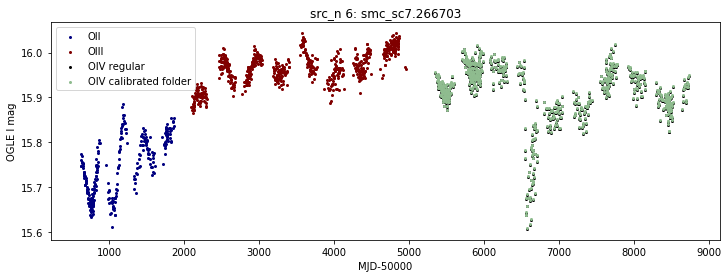

In [222]:
plt.figure(figsize=(12,4))
plt.scatter(i26['MJD-50000'],i26['I mag'],color='navy',s=4,label='OII')
plt.scatter(i36['MJD-50000'],i36['I mag'],color='maroon',s=4,label='OIII')
plt.scatter(i46['MJD-50000'],i46['I mag'],color='black',s=4,label='OIV regular')
plt.scatter(i46cal['MJD-50000'],i46cal['I mag'],color='darkseagreen',s=4,label='OIV calibrated folder')
plt.legend()
plt.ylabel('OGLE I mag')
plt.xlabel('MJD-50000')
plt.title('src_n 6: '+name6)
# png('src6cal')

# Automatic Periodogram, V-I, and LC zoom-in
- see how succesfully it picks out diff trends if periodograms are done on different scales
- fold with known orbital period

Text(0.5, 0, 'MJD-50000')

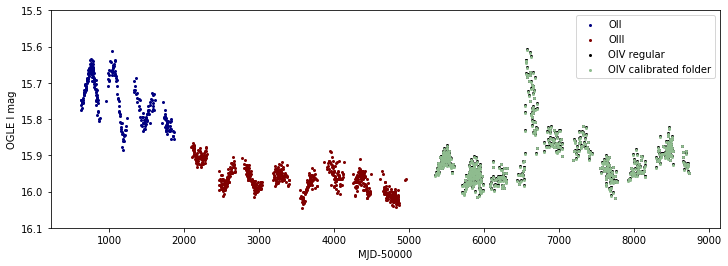

In [229]:
plt.figure(figsize=(12,4))
plt.scatter(i26['MJD-50000'],i26['I mag'],color='navy',s=4,label='OII')
plt.scatter(i36['MJD-50000'],i36['I mag'],color='maroon',s=4,label='OIII')
plt.scatter(i46['MJD-50000'],i46['I mag'],color='black',s=4,label='OIV regular')
plt.scatter(i46cal['MJD-50000'],i46cal['I mag'],color='darkseagreen',s=4,label='OIV calibrated folder')
plt.legend()
plt.ylim(16.1,15.5)
plt.ylabel('OGLE I mag')
plt.xlabel('MJD-50000')

In [226]:
#fold with known orbital period -- after detrending?
src6['Porb']

17.2


In [238]:
Imag=i26['I mag']
window=201 #also tested other windows to make sure periodogram results unaffected
print('Smooth (window = ', window, ') and detrend data...')
Ismooth = signal.savgol_filter(Imag, window, 1)
Imean = np.mean(Imag)
print('Average I band magnitude', Imean)
i26['I detrend'] = Imag-Ismooth  + Imag.mean()

print('min:',i26['I detrend'].min(),'max:',i26['I detrend'].max())

Smooth (window =  201 ) and detrend data...
Average I band magnitude 15.74005629139073
min: 15.625120968007648 max: 15.871489127211625


In [265]:
#detrending function
def detrend(tab,window=201,printall=False,plot=False):
    Imag = tab['I mag']
    if printall: print('Smooth (window = ', window, ') and detrend data...')
    Ismooth = signal.savgol_filter(Imag, window, 1)
    Imean = np.mean(Imag)
    if printall: print('Average I band magnitude', Imean)
    tab['I detrend'] = Imag-Ismooth  + Imag.mean()

    if printall: print('min:',i26['I detrend'].min(),'max:',i26['I detrend'].max())
    if plot:
        plt.scatter(tab['MJD-50000'],tab['I mag'],color='black',label='original')
        plt.scatter(tab['MJD-50000'],tab['I detrend'],color='darkseagreen',label='detrended')
        plt.legend()

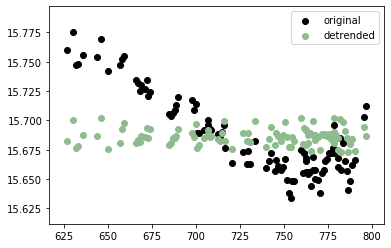

In [277]:
#can detrend small part
smalli26 = i26[:100]
detrend(smalli26,window=5,plot=True)

<Quantity 18.13644034>

<Figure size 576x288 with 0 Axes>

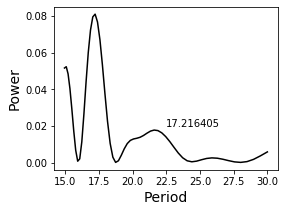

<Figure size 576x288 with 0 Axes>

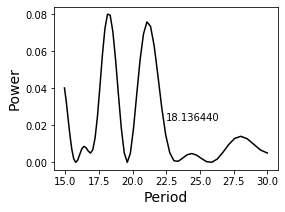

In [294]:
periodogram(smalli26,detrend=True,minp=15)
periodogram(smalli26,minp=15)

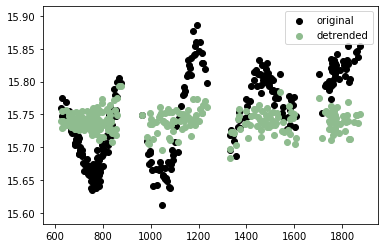

In [271]:
detrend(i26,window=11,plot=True)

In [301]:
def periodogram(tab,det=False,more=False,minp=5,maxp=30,bayes=False,sub=False,figsize=(4,3),plot=True,dodetrend=False,window=11):
    '''Perform and plot single LS periodogram.
    Two different return options.'''
    
    t = tab['MJD-50000']
    if dodetrend:
        #decide whether to actually modify tab or create copy just for periodogram
        detrend(tab,window=window)
    if det: y = tab['I detrend']
    else: y = tab['I mag']
    dy = tab['I mag err']
    fig = plt.figure(figsize=(8, 4))
    minf = 1./maxp
    maxf = 1./minp
    ls = LombScargle(t, y)
    freq, power = ls.autopower(normalization='standard',
                           minimum_frequency=minf,
                           maximum_frequency=maxf,
                           samples_per_peak=10)
    if bayes: power = np.exp(power)
        
    best_freq = freq[np.argmax(power)]

    if plot:
        fig = plt.figure(figsize=figsize)
        plt.plot(1/freq,power,color='black')
        plt.xlabel('Period',fontsize=14)
        plt.ylabel('Power',fontsize=14)
        #put text with best period
        plt.text(minp+(maxp-minp)/2,0.8*np.max(power),f'{1/best_freq:2f}')
    if more:
        return freq, power, 1/best_freq
    else:
        return 1/best_freq

<Quantity 17.12436026>

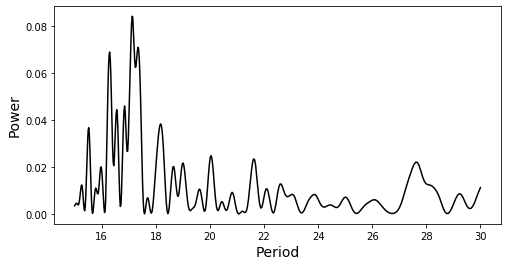

In [272]:
periodogram(i26,det=True,minp=15) #varies by detrending window, so maybe can try a few and plot results as function of window

<Quantity 17.37370255>

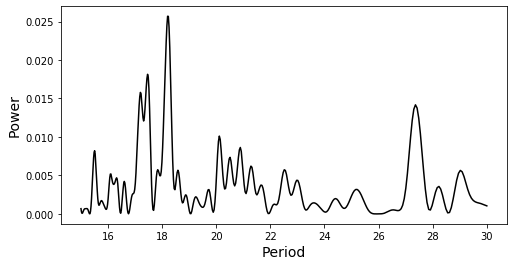

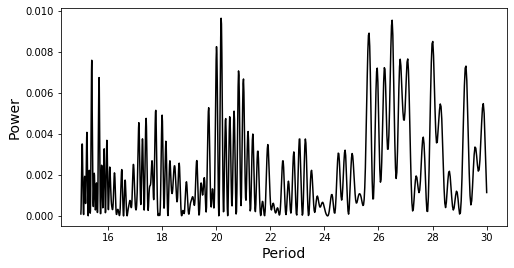

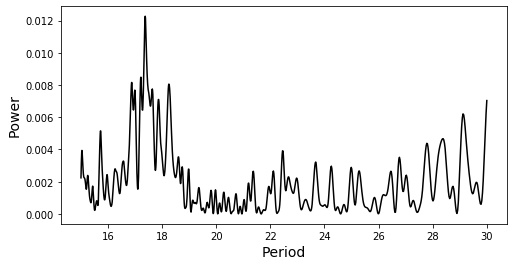

In [251]:
#trying to get orbital period with two larger underlying trends still thre
periodogram(i26,det=True,minp=15)
periodogram(i36,minp=15)
periodogram(i46,minp=15)

18.136440341418286
26.652046512001824


<Quantity 21.54898214>

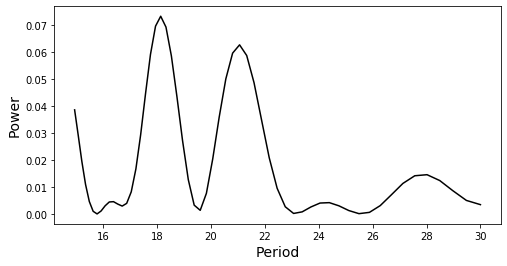

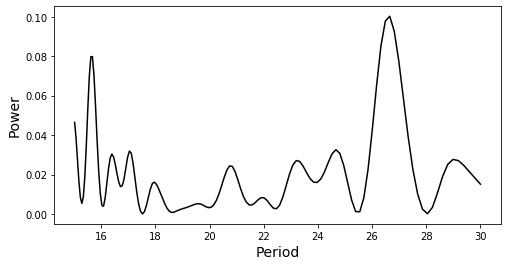

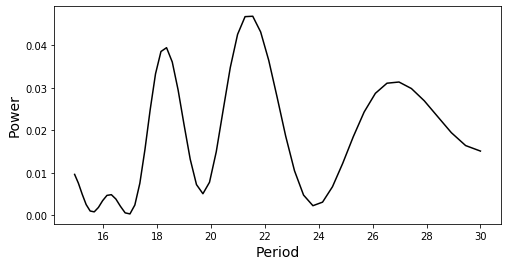

In [257]:
#trying to get orbital period by just taking smaller window
print(periodogram(i26[:100],deet=True,minp=15))
print(periodogram(i36[:100],minp=15))
periodogram(i46[:100],minp=15)

<Quantity 17.37370255>

<Figure size 576x288 with 0 Axes>

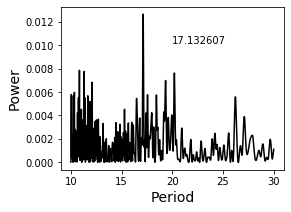

<Figure size 576x288 with 0 Axes>

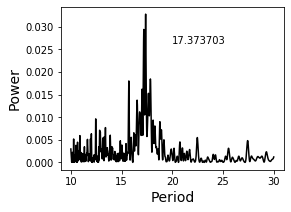

In [304]:
periodogram(i36,minp=10,det=True,dodetrend=True,window=5)
periodogram(i46,minp=10,det=True,dodetrend=True,window=5)

going forward can do some number of points as window or some range of time based on known period, regardless of sampling

# Review So Far
- steps
    - grab names from original og2, og3, og4 tables after taking src from merged
    - also grab and print orbital period (and any other relevant table data)
    - identify I and V band files in glob lists
    - plot full LC 
    - plot two levels of zoom in, one informed by orbital period
        - identify a window that repeats the orbital period a few times and make separate table
        - helpful for plot limits and detrending
    - do a few iterations of detrending and periodograms
        - some range of large-scale pattern search using all three tables
        - within each table and overall look for medium-sized trend with and without detrending (large window)
        - smallest scale variation (for now): probs the orbital period
            - smaller detrending window and run periodogram within each og
            - phase-fold
            
- plots and numbers to return
    - full LC
    - two scales of zoom in (informed by multiples of orbital period)
    - a bunch of periodogram results can be arranged in a table
    - periodogram number results on full LC, on each OG (for first pass at changing period)
    - periodogram results on smaller/medium windows, with and without detrending 
    - phase-folded plots? maybe if above some power...

# Adding V-I for Same Source
- probably will want to do interpolation --> V-I --> plot line of best fit and give sense of outliers (maybe outliers as function of brightness)


In [314]:
p1[p1['src_n']==6]['Porb'][0]


17.2

In [339]:
def findfiles(srcnum,band='I',ogs=['II','III','IV']):
    '''Return a table for each requested file for one source
    Probably better to do all name cross-referencing rather than looping over and over
    But can use some of these techniques (still loop but after each success take out of lists)'''
    #get row from full table
    row = p1[p1['src_n']==srcnum]
    print('orbital period: ',row['Porb'][0])
    n1 = row['name1'][0]
    n2 = row['name2'][0]
    print('n1,n2:',n1,n2)

    #later can restructure to pass in og tables instead of II,III,IV
    lcs = []
    if 'II' in ogs:
        #get names from og2 table; assumes these tables exist in notebook so can change to arg later
        name1 = og2[og2['src_n']==srcnum]['name1'][0]
        name2 = og2[og2['src_n']==srcnum]['name2'][0]
        print(name1,name2)
        #glob files from directory of OII for V or I
        og2files = glob.glob('smc_list/OGLE-II/'+band+'/*')
        for i in og2files:
            #can refine this to just be whichever is relevant for a given band or og
            if name1 in i or name2 in i or n1 in i or n2 in i:
                print(i)
                og2lc = i
                lcs.append(og2lc)
    if 'III' in ogs:
        #get names from og2 table; assumes these tables exist in notebook so can change to arg later
        name1 = og3[og3['src_n']==srcnum]['name1'][0]
        name2 = og3[og3['src_n']==srcnum]['name2'][0]
        print(name1,name2)

        #glob files from directory of OII for V or I
        og3files = glob.glob('smc_list/OGLE-III/'+band+'/*')
        for i in og3files:
            #can refine this to just be whichever is relevant for a given band or og
            if name1 in i or name2 in i or n1 in i or n2 in i:
                print(i)
                og3lc = i
                lcs.append(og3lc)
    if 'IV' in ogs:
        #get names from og2 table; assumes these tables exist in notebook so can change to arg later
        name1 = og4int[og4int['src_n']==srcnum]['name1'][0]
        print(name1)
        #glob files from directory of OII for V or I
        og4files = glob.glob('smc_list/OGLE-IV/'+band+'/CALIBRATED/*')
        for i in og4files:
            #can refine this to just be whichever is relevant for a given band or og
            if name1 in i or n1 in i or n2 in i:
                print(i)
                og4lc = i
                lcs.append(og4lc)
    return lcs

In [340]:
vlcs6 = findfiles(6,band='V') #not finding OIII and OIV V band files
#method does work for I band

orbital period:  17.2
n1,n2: smc719.18.378 smc_sc7.266703
smc719.18.378 smc_sc7.266703
smc_list/OGLE-II/V/smc_sc7.266703.dat
smc719.18.378 smc108.8.26225
smc719.18.378


In [353]:
v26 = Table.read(vlcs6[0],format='ascii',names=['MJD-50000','V mag','V mag err'])

(15.951, 15.562)

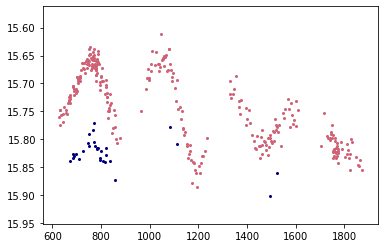

In [363]:
#plot I and V band data
plt.scatter(v26['MJD-50000'],v26['V mag'],color='navy',s=4)
plt.scatter(i26['MJD-50000'],i26['I mag'],color=c4,s=4)
plt.ylim(np.max(v26['V mag'])+.05,np.min(i26['I mag'])-.05)

In [360]:
#interpolate I and plot V vs. V-I etc.
i_interp6 = np.interp(v26['MJD-50000'],i26['MJD-50000'],i26['I mag'])


(15.951, 15.562)

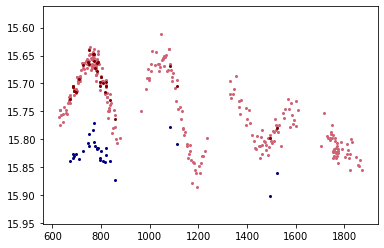

In [366]:
#plot I and V band data
plt.scatter(v26['MJD-50000'],v26['V mag'],color='navy',s=4)
plt.scatter(i26['MJD-50000'],i26['I mag'],color=c4,s=4)
#interpolated I band at V 
plt.scatter(v26['MJD-50000'],i_interp6,color=c5,s=4)

plt.ylim(np.max(v26['V mag'])+.05,np.min(i26['I mag'])-.05)

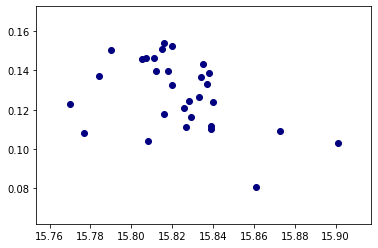

In [368]:
#plot V vs V-I
plt.scatter(v26['V mag'],v26['V mag']-i_interp6,color='navy')


(15.82, 15.625)

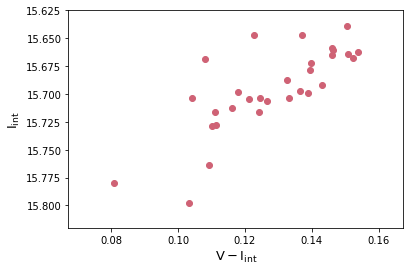

In [379]:
#plot I_int vs. V-I
#seems to ususally look better?
#positive corr would be redder when brighter
plt.scatter(v26['V mag']-i_interp6,i_interp6,color=c4)
plt.xlabel('$\mathrm{V-I_{int}}$',fontsize=13)
plt.ylabel('$\mathrm{I_{int}}$',fontsize=13)
plt.ylim(15.82,15.625)

#### add best fit line and correlation or residuals

# Cross-Referencing Function
- so that files matched with objects

- src numbers from p1 table (as well as orbital periods)
- go by folder
    - e.g. get files in OII I band folder --> 

In [383]:
p1[:2] #could also just add to this table but easier for now to make smaller one; can always stack them

src_n,OGLE,RA_OGLE,DEC_OGLE,ra_deg,dec_deg,perr,period,Porb,_RAJ2000_1,_DEJ2000_1,__M2002_,Vmag_1,Separation_1,_RAJ2000_2,_DEJ2000_2,Vmag_2,recno,Separation,name1,name2
int64,str38,str11,str11,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,str15,str15
2,SMC732.03 \#3540,01:21:40.61,-72:57:30.9,20.41893,-72.95907,2.0,2.165,84.0,20.418999999999993,-72.95847222222221,80352,14.28,2.147142505236131,--,--,--,--,--,smc732.03.3540,smc120.1.5
3,SMC720.17 \#50,00:54:33.44,-73:41:01.3,13.639167,-73.68364,0.8,2.37,18.38,13.639333333333331,-73.68369444444444,30492,14.51,0.2597014565010407,13.639544999999995,-73.68356999999999,14.729,2675272,0.4570936647419033,smc720.17.50,smc107.5.22


In [464]:
#make table with source number, file names, orbital period
arr = {'src_n': p1['src_n'],
       'Porb': p1['Porb'],
       'RA_OGLE': p1['RA_OGLE'],
      'DEC_OGLE': p1['DEC_OGLE']}
filetab = Table(arr)
# filetab = Table(names=['src_n','Porb','RA_OGLE','DEC_OGLE','OII I','OIII I','OIV I','OII V','OIII V','OIV V'])

In [465]:
filetab[:2]

src_n,Porb,RA_OGLE,DEC_OGLE
int64,float64,str11,str11
2,84.0,01:21:40.61,-72:57:30.9
3,18.38,00:54:33.44,-73:41:01.3


## checking what's going on with multiple rows of same src num (see duplicates below)
## also something going on with V band names -- V file OIII names not coming up in PartI_OIII

In [406]:
og3[20:30]

src_n,name1,name2
int64,str15,str14
24,smc719.19.162,smc105.5.31239
24,smc719.19.162,smc108.8.8659
25,smc726.27.20665,smc110.3.15926
25,smc726.27.20665,smc110.4.3589
26,smc719.05.41432,smc100.5.44537
26,smc719.05.41432,smc101.8.14265
27,smc719.11.36482,smc101.2.14349
28,smc719.21.21951,smc102.1.38
30,smc726.15.77,smc106.7.18880


In [407]:
'smc100.2.42261.dat' in og3['name1']

False

In [408]:
'smc719.19.162' in og3['name1']

True

In [409]:
'smc111.3.3.dat' in og3['name1'] or 'smc111.3.3.dat' in og3['name2']

False

In [411]:
'smc719.26.44.dat' in og4int['name1']

False

In [412]:
og4['name1'][:3]

smc732.03.3540
smc720.17.50
smc718.01.10792


In [414]:
'smc726.20.27602.dat' in og4['name1']

False

go forward with function but definitely ask about this
- V band names don't actually match up with og tables?

In [492]:
o2idict = dict.fromkeys(filetab['src_n'], '')

In [493]:
#just do I band for now
#start with OII
idir = 'smc_list/OGLE-II/I/'
#same as iog2 but make new one and delete from it

i2f = glob.glob(idir+'*')#I band o2 files
i2f[:5]

['smc_list/OGLE-II/I/smc_sc4.156251.dat',
 'smc_list/OGLE-II/I/smc_sc8.94537.dat',
 'smc_list/OGLE-II/I/smc_sc7.70829.dat',
 'smc_list/OGLE-II/I/smc_sc5.145678.dat',
 'smc_list/OGLE-II/I/smc_sc8.139407.dat']

In [494]:
#repeat with V band
vdir = 'smc_list/OGLE-II/V/'
#same as iog2 but make new one and delete from it

v2f = glob.glob(vdir+'*')#V band o2 files
v2f[:2]

['smc_list/OGLE-II/V/smc_sc4.156251.dat',
 'smc_list/OGLE-II/V/smc_sc8.94537.dat']

In [491]:
o2vdict = dict.fromkeys(filetab['src_n'], '')

In [495]:
print(len(v2f),len(i2f))

71 71


In [496]:
#loop thru og2 sources, not filetab, since not all filetab in og2
for s in og2['src_n']:
    #get source names from og2 table
    #seems to be V band name
    name1 = og2[og2['src_n']==s]['name1'][0]
    #I band name
    name2 = og2[og2['src_n']==s]['name2'][0]
    #find file in i2f with src name in it
    if vdir+name1+'.dat' in v2f:
        #add to dictionary
        o2vdict[s] = vdir+name1+'.dat'
        print(s,'V found with name1')
        #delete string from v2f
        v2f.remove(vdir+name1+'.dat')
    elif vdir+name2+'.dat' in v2f:
        #add to dictionary
        o2vdict[s] = vdir+name2+'.dat'
        print(s,'V band found with name 2')
        v2f.remove(vdir+name2+'.dat')
    else: print(s,'source not found in V folder')
    if idir+name2+'.dat' in i2f:
        print(s,'I found with name2')
        o2idict[s] = idir+name2+'.dat'
        i2f.remove(idir+name2+'.dat')

    elif idir+name1+'.dat' in i2f:
        print(s,'I found with name1')
        o2idict[s] = idir+name1+'.dat'
        i2f.remove(idir+name1+'.dat')
    else: print(s,'source not found in I folder')

6 V band found with name 2
6 I found with name2
7 V band found with name 2
7 I found with name2
10 V band found with name 2
10 I found with name2
11 V band found with name 2
11 I found with name2
12 V band found with name 2
12 I found with name2
15 V band found with name 2
15 I found with name2
16 V band found with name 2
16 I found with name2
21 V band found with name 2
21 I found with name2
24 V band found with name 2
24 I found with name2
25 V band found with name 2
25 I found with name2
26 V band found with name 2
26 I found with name2
27 V band found with name 2
27 I found with name2
37 V band found with name 2
37 I found with name2
38 V band found with name 2
38 I found with name2
39 V band found with name 2
39 I found with name2
40 V band found with name 2
40 I found with name2
41 V band found with name 2
41 I found with name2
45 V band found with name 2
45 I found with name2
46 V band found with name 2
46 I found with name2
47 V band found with name 2
47 I found with name2
48 V

In [516]:
#all but one source found
len(i2f) #succesfully deleted 

37

In [517]:
71-37

34

In [511]:
filetab['OII I'] = list(o2idict.values())
filetab['OII V'] = list(o2vdict.values())

In [512]:
filetab[:5]

src_n,Porb,RA_OGLE,DEC_OGLE,OII I,OII V
int64,float64,str11,str11,str38,str38
2,84.0,01:21:40.61,-72:57:30.9,,
3,18.38,00:54:33.44,-73:41:01.3,,
4,82.37,00:59:12.74,-71:38:44.9,,
5,--,00:51:38.79,-72:17:04.8,,
6,17.2,00:57:02.19,-72:25:55.4,smc_list/OGLE-II/I/smc_sc7.266703.dat,smc_list/OGLE-II/V/smc_sc7.266703.dat


In [514]:
len(i2f)

37

In [646]:
#repeat for og3 and og4
#define dictionaries
o3idict = dict.fromkeys(filetab['src_n'], '')
o3vdict = dict.fromkeys(filetab['src_n'], '')
o4idict = dict.fromkeys(filetab['src_n'], '')
o4vdict = dict.fromkeys(filetab['src_n'], '')

#get directories and files
i3dir = 'smc_list/OGLE-III/I/'
v3dir = 'smc_list/OGLE-III/V/'
i3f = glob.glob(i3dir+'*')
v3f = glob.glob(v3dir+'*')
#directories and files for og4: use calibrated
i4dir = 'smc_list/OGLE-IV/I/CALIBRATED/'
v4dir = 'smc_list/OGLE-IV/V/CALIBRATED/'
i4f = glob.glob(i4dir+'*')
v4f = glob.glob(v4dir+'*')

In [608]:
cross3 = Table.read('smc_list/IV_OIII.cross',format='ascii',names=['Iname','Vname'])
cross4 = Table.read('smc_list/IV_OIV.cross',format='ascii',names=['Iname','Vname'])

In [620]:
og3[og3['src_n']==51]['name2'][0]

'smc105.5.24164'

In [647]:
for s in og3['src_n']:
    #get source names from og2 table
    #I band name
    name2 = og3[og3['src_n']==s]['name2'][0]
    #corresponding V band name from cross
    crname = cross3[cross3['Iname']==name2]['Vname'][0]
#     name1 = og3[og3['src_n']==s]['name1'][0]
    if v3dir+crname+'.dat' in v3f:
        #add to dictionary
        o3vdict[s] = v3dir+crname+'.dat'
        print(s,'V found with cross name')
        #delete string from v2f
        v3f.remove(v3dir+crname+'.dat')

    else: print(s,'source not found in V folder')
    if i3dir+name2+'.dat' in i3f:
        print(s,'I found with name2')
        o3idict[s] = i3dir+name2+'.dat'
        i3f.remove(i3dir+name2+'.dat')
#     elif i3dir+name1+'.dat' in i3f:
#         print(s,'I found with name1')
#         o3idict[s] = i3dir+name1+'.dat'
#         i3f.remove(i3dir+name1+'.dat')
    else: print(s,'source not found in I folder')

2 V found with cross name
2 I found with name2
3 V found with cross name
3 I found with name2
4 V found with cross name
4 I found with name2
5 V found with cross name
5 I found with name2
6 V found with cross name
6 I found with name2
7 V found with cross name
7 I found with name2
9 V found with cross name
9 I found with name2
10 V found with cross name
10 I found with name2
11 V found with cross name
11 I found with name2
12 V found with cross name
12 I found with name2
13 V found with cross name
13 I found with name2
15 V found with cross name
15 I found with name2
16 V found with cross name
16 I found with name2
17 V found with cross name
17 I found with name2
20 V found with cross name
20 I found with name2
21 V found with cross name
21 I found with name2
22 V found with cross name
22 I found with name2
23 V found with cross name
23 I found with name2
23 source not found in V folder
23 source not found in I folder
23 source not found in V folder
23 source not found in I folder
24 V

o3idict only missing two files
- above print statements show more b/c of duplicated source numbers

In [638]:
filetab['OIII I'] = list(o3idict.values())
filetab['OIII V'] = list(o3vdict.values())

In [643]:
og3[og3['src_n']==2]['name1'][0]

'smc732.03.3540'

In [645]:
len(i4f)

51

In [648]:
#lastly: og4 (srcs with integer values for now)
#og4 names in table not finding
for s in og4int['src_n']:
    #get source names from og2 table
    #only one name
    name1 = og4int[og4int['src_n']==s]['name1'][0]
    #not a cross name for everything
    if name1 in cross4['Iname']:
        crname = cross4[cross4['Iname']==name1]['Vname'][0]
    else: crname = name1
    #find file in i2f with src name in it
    if v4dir+crname+'.dat' in v4f:
        #add to dictionary
        o4vdict[s] = v4dir+crname+'.dat'
        print(s,'V found with name1')
        #delete string from v2f
        v4f.remove(v4dir+crname+'.dat')
    else: print(s,'source not found in V folder')
    if i4dir+name1+'.dat' in i4f:
        print(s,'I found with name1')
        o4idict[s] = i4dir+name1+'.dat'
        i4f.remove(i4dir+name1+'.dat')
    else: print(s,'source not found in I folder')

2 source not found in V folder
2 I found with name1
3 V found with name1
3 I found with name1
4 V found with name1
4 I found with name1
5 V found with name1
5 I found with name1
6 V found with name1
6 I found with name1
7 V found with name1
7 I found with name1
9 V found with name1
9 I found with name1
10 V found with name1
10 I found with name1
11 V found with name1
11 I found with name1
12 V found with name1
12 I found with name1
13 V found with name1
13 I found with name1
14 V found with name1
14 I found with name1
15 V found with name1
15 I found with name1
16 V found with name1
16 I found with name1
17 V found with name1
17 I found with name1
20 source not found in V folder
20 I found with name1
21 V found with name1
21 I found with name1
22 V found with name1
22 I found with name1
23 V found with name1
23 I found with name1
24 V found with name1
24 I found with name1
25 V found with name1
25 I found with name1
26 V found with name1
26 I found with name1
27 V found with name1
27 I

In [649]:
filetab['OIV I'] = list(o4idict.values())
filetab['OIV V'] = list(o4vdict.values())

In [650]:
filetab[:5]

src_n,Porb,RA_OGLE,DEC_OGLE,OII I,OII V,OIII I,OIII V,OIV I,OIV V
int64,float64,str11,str11,str38,str38,str38,str38,str49,str49
2,84.0,01:21:40.61,-72:57:30.9,,,smc_list/OGLE-III/I/smc120.1.5.dat,smc_list/OGLE-III/V/smc120.1.5.dat,smc_list/OGLE-IV/I/CALIBRATED/smc732.03.3540.dat,
3,18.38,00:54:33.44,-73:41:01.3,,,smc_list/OGLE-III/I/smc107.5.22.dat,smc_list/OGLE-III/V/smc107.5.5.dat,smc_list/OGLE-IV/I/CALIBRATED/smc720.17.50.dat,smc_list/OGLE-IV/V/CALIBRATED/smc720.17.19.dat
4,82.37,00:59:12.74,-71:38:44.9,,,smc_list/OGLE-III/I/smc109.2.21.dat,smc_list/OGLE-III/V/smc109.2.5.dat,smc_list/OGLE-IV/I/CALIBRATED/smc718.01.10792.dat,smc_list/OGLE-IV/V/CALIBRATED/smc718.01.21607.dat
5,--,00:51:38.79,-72:17:04.8,,,smc_list/OGLE-III/I/smc101.4.21932.dat,smc_list/OGLE-III/V/smc101.4.39141.dat,smc_list/OGLE-IV/I/CALIBRATED/smc719.21.22049.dat,smc_list/OGLE-IV/V/CALIBRATED/smc719.21.39743.dat
6,17.2,00:57:02.19,-72:25:55.4,smc_list/OGLE-II/I/smc_sc7.266703.dat,smc_list/OGLE-II/V/smc_sc7.266703.dat,smc_list/OGLE-III/I/smc108.8.26225.dat,smc_list/OGLE-III/V/smc108.8.30808.dat,smc_list/OGLE-IV/I/CALIBRATED/smc719.18.378.dat,smc_list/OGLE-IV/V/CALIBRATED/smc719.18.340.dat


In [651]:
ascii.write(filetab,'sourcefiles.csv',format='csv')